# ARIMAX Gold and S&P500 Time Series: 
## Part 1 - Data Wrangling

For this capstone I have collected a total of five different csv files. They are:
1. "gold-price-last-ten-years.csv"
2. "SP500 2007-2020.csv"
3. "silver history.csv"
4. "Barrick Gold Corp 1985-2020.csv"

The purpose of this capstone is to conduct a small scale test on the belief that the value of GLD increases when the value of stock market indexes decreases (represented by the S&P500 index). To add some additional insight and food for thought, I have included several other sets of data: the value of silver and the stock value of Barrick Gold Corp (a gold mining company). The reasoning for including silver is to see if this trend is unique to gold, or if other precious metals increase in value as the stock market declines. The stock value of Barrick Gold Corp. is included in order to see if the stock value of gold mining companies also increases in value in correlation to the value of gold and the S&P500 index.

Hypothesis: When the S&P500 index goes down in value (represented by the S&P500 index), the value of gold increases.

Null Hypothesis: S&P500 index value dropping will not have a statistically significant, positive effect on the stock value of Gold.

After discovering any significant relationships between the indexes/stocks, I will write a time series in order to see how well we can predict one based off of another.

To begin, I will clean the data in order to properly merge and compare it in a single dataframe.

In [1]:
# To begin, I will import the "gold-price-last-ten-years.csv," and "SP500 2007-2020.csv" 
# in order to merge them together along the date column.

import pandas as pd # for importing, reading, cleaning csv files
import numpy as np # for maths, of course
import matplotlib.pyplot as plt # so we can plot
from matplotlib.pylab import rcParams #
import seaborn as sns # so we can beautify the plots
from statsmodels.tsa.stattools import adfuller # for our Dicky Fuller tests.
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
import statsmodels.api as sm # in case I think of anything else I need and didn't bring in here
from sklearn.model_selection import train_test_split # For splitting data effectively
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import warnings # For handling error messages.

path = 'C:\\Users\\mccal\\Desktop\\Springboard Files\\Springboard Capstone data\\BTG Capstone\\'

# There is a lot of text prior to the actual columns, so the header has
# been set appropriatley.
gold = pd.read_csv('gold-price-last-ten-years.csv', sep=',', header=8)

gold.head()

,date,value
0,2010-08-25,1237.50
1,2010-08-26,1240.25
2,2010-08-27,1234.50
3,2010-08-31,1233.50
4,2010-09-01,1250.00


[Stock trending time period reference](https://www.investors.com/how-to-invest/investors-corner/sell-rules-growth-stocks-break-uptrend-line/#:~:text=A%20properly%20drawn%20trend%20line,of%20at%20least%2018%20weeks.)

In [2]:
# First things first, change 'date' column to actual date 
# format with 'pd.to_datetime()'
gold['date']=pd.to_datetime(gold['date'])

# Establish which dates we want to focus on and remove the dates we don't care about from the data.
# 18 weeks is the minimum time period to be considered a "trend" in stock prices. I chose August 21, 2017, as it will leave
# a healthy set of trend data as the test split. Click the link above if you want to no more!
focus = (gold['date'] > '2017-08-21') & (gold['date'] <= '2020-08-21')

# Assign into a main data frame to preserve gold in case we want it later
maindf = gold.loc[focus]

maindf.head()

,date,value
1780,2017-08-22,1291.0
1781,2017-08-23,1294.7
1782,2017-08-24,1292.0
1783,2017-08-25,1297.9
1784,2017-08-28,1315.3


In [3]:
# Renaming the columns to something more 'formal' helps me visualize 
# the final plot and table I have in mind.
maindf.columns = ['Date', 'GLD(USD)']
maindf.head()

,Date,GLD(USD)
1780,2017-08-22,1291.0
1781,2017-08-23,1294.7
1782,2017-08-24,1292.0
1783,2017-08-25,1297.9
1784,2017-08-28,1315.3


In [4]:
# We are going to be checking for NaN values in the data quite 
# frequently in order to monitor changes and loss of data as we clean. 
# Best to write a function for checking NaN now and speed things up! Let's
# have a function that gives us the percentage that NaN values make up in 
# the data.
def show_na(df):
    na_df = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
    na_df.columns=['count', '%']
    na_df.sort_values(by='count', ascending = False)
    return na_df
# Use the function
show_na(maindf)

#Sweet, no Nan's thus far.

,count,%
Date,0,0.0
GLD(USD),0,0.0


Now that I have imported and sorted Gold(GLD), it's time to bring in a second dataframe and begin merging them together. 
Each of the dataframes I have for this project have different start dates, but they all have the same end date. So, in order to have consistency across all of the data, I am going to import the Bitcoin(BTC) dataframe next, as it has the most recent start date of 09-17-2014.
Then I will merge BTC along the 'Date' column of our main dataframe. This way the dataframe will only keep the dates which they share.

So, first thing I notice is new Nan's, which means that there were new dates added. This makes sense as Bitcoin is traded all day, every day and the stock market is closed on weekends and certain holidays. So, with that said, we should have about 30% Nan values in the Gold data set. We  will address this at the end. 

In [5]:
# Import the next csv and repeat
SP500=pd.read_csv('SP500 2007-2020.csv', sep=',', header=7)
SP500['date'] = pd.to_datetime(SP500['date'])
# Rename columns for appropriate representation.
SP500.columns = ['Date', 'SPX(USD)']
# Since GLD and S&P500 are both stock indexes, they should have almost identical Nan's.
maindf=maindf.merge(SP500, how='left', on='Date')
show_na(maindf)

,count,%
Date,0,0.000000
GLD(USD),0,0.000000
SPX(USD),16,2.108037


In [6]:
# Again, repeat for the remaining CSV's
barrick = pd.read_csv('Barrick Gold Corp 1985-2020.csv', sep=',', header=9)
barrick['date'] = pd.to_datetime(barrick['date'])
barrick = barrick[['date', 'close']]
barrick.columns = ['Date','BARR(USD)']
maindf = maindf.merge(barrick, how='left', on='Date')
maindf.head()

,Date,GLD(USD),SPX(USD),BARR(USD)
0,2017-08-22,1291.0,2452.51,16.5072
1,2017-08-23,1294.7,2444.04,16.6639
2,2017-08-24,1292.0,2438.97,16.6932
3,2017-08-25,1297.9,2443.05,16.7814
4,2017-08-28,1315.3,2444.24,17.3003


In [7]:
silver = pd.read_csv('silver history.csv', sep=',', header=7)
silver['date']=pd.to_datetime(silver['date'])
silver.columns = ['Date', 'SLV(USD)']
maindf = maindf.merge(silver, how='left', on='Date')
maindf.head()

,Date,GLD(USD),SPX(USD),BARR(USD),SLV(USD)
0,2017-08-22,1291.0,2452.51,16.5072,17.060
1,2017-08-23,1294.7,2444.04,16.6639,17.126
2,2017-08-24,1292.0,2438.97,16.6932,17.046
3,2017-08-25,1297.9,2443.05,16.7814,17.132
4,2017-08-28,1315.3,2444.24,17.3003,17.529


In [8]:
# Check for NaN's
show_na(maindf)

,count,%
Date,0,0.000000
GLD(USD),0,0.000000
SPX(USD),16,2.108037
BARR(USD),16,2.108037
SLV(USD),11,1.449275


In [9]:
# Check for duplicate dates before setting index on "Date"
maindf['Date'].value_counts().head()

2018-12-21    1
2019-09-02    1
2019-05-24    1
2020-07-14    1
2018-01-30    1
Name: Date, dtype: int64

In [10]:
#Set index to 'Date'  for graphing and visualization
maindf= maindf.set_index('Date')
maindf.head()

,GLD(USD),SPX(USD),BARR(USD),SLV(USD)
Date,,,,
2017-08-22,1291.0,2452.51,16.5072,17.060
2017-08-23,1294.7,2444.04,16.6639,17.126
2017-08-24,1292.0,2438.97,16.6932,17.046
2017-08-25,1297.9,2443.05,16.7814,17.132
2017-08-28,1315.3,2444.24,17.3003,17.529


In [11]:
# Now, to deal with the Nan's. The best option I propose is to forward fill the missing values since 
# the values do not change much over the weekends. Lets be careful, though, and observe the mean, std deviation, 
# etc of each column before we use ffill.
maindf.describe()

,GLD(USD),SPX(USD),BARR(USD),SLV(USD)
count,759.000000,743.000000,743.000000,748.000000
mean,1405.848419,2846.261023,16.046517,16.575697
std,186.315921,226.333878,4.703624,2.132119
min,1176.700000,2237.400000,9.666000,11.772000
25%,1281.300000,2688.700000,12.871200,15.242500
50%,1324.950000,2821.930000,14.123100,16.463300
75%,1503.750000,2978.735000,17.760450,17.279250
max,2061.500000,3397.160000,30.130000,29.261000


In [12]:
# Now use ffill to remove the Nan's
maindf = maindf.fillna(axis=0, method='ffill')
# Lets look at the overall summary of each column again.
maindf.describe()

,GLD(USD),SPX(USD),BARR(USD),SLV(USD)
count,759.000000,759.000000,759.000000,759.000000
mean,1405.848419,2846.759908,16.037577,16.573859
std,186.315921,227.016344,4.687174,2.123482
min,1176.700000,2237.400000,9.666000,11.772000
25%,1281.300000,2688.700000,12.882800,15.244900
50%,1324.950000,2820.400000,14.123100,16.460600
75%,1503.750000,2979.075000,17.760900,17.282500
max,2061.500000,3397.160000,30.130000,29.261000


So using ffill had no significant impact on the std dev or mean for any of the columns. We can see that the strongest change was probably to silver, with its std dev going from 1.825 to 1.787.  Still, not significant. 

In [13]:
# Double check, but there should't be any nan values now.
maindf.isnull().sum()

GLD(USD)     0
SPX(USD)     0
BARR(USD)    0
SLV(USD)     0
dtype: int64

Sweet, so everything is clean now. No duplicate dates and no NaN  values. Now lets finally take a look to see if there  is any correlation among these datasets. Lets first look at a timeline graph of all the columns to see if anything stands out.

I am going to save the data as a separate .csv so that we have it saved in case anything happens or we need it on a separate drive.

## Part 2: EDA

Text(0, 0.5, 'Value(USD)')

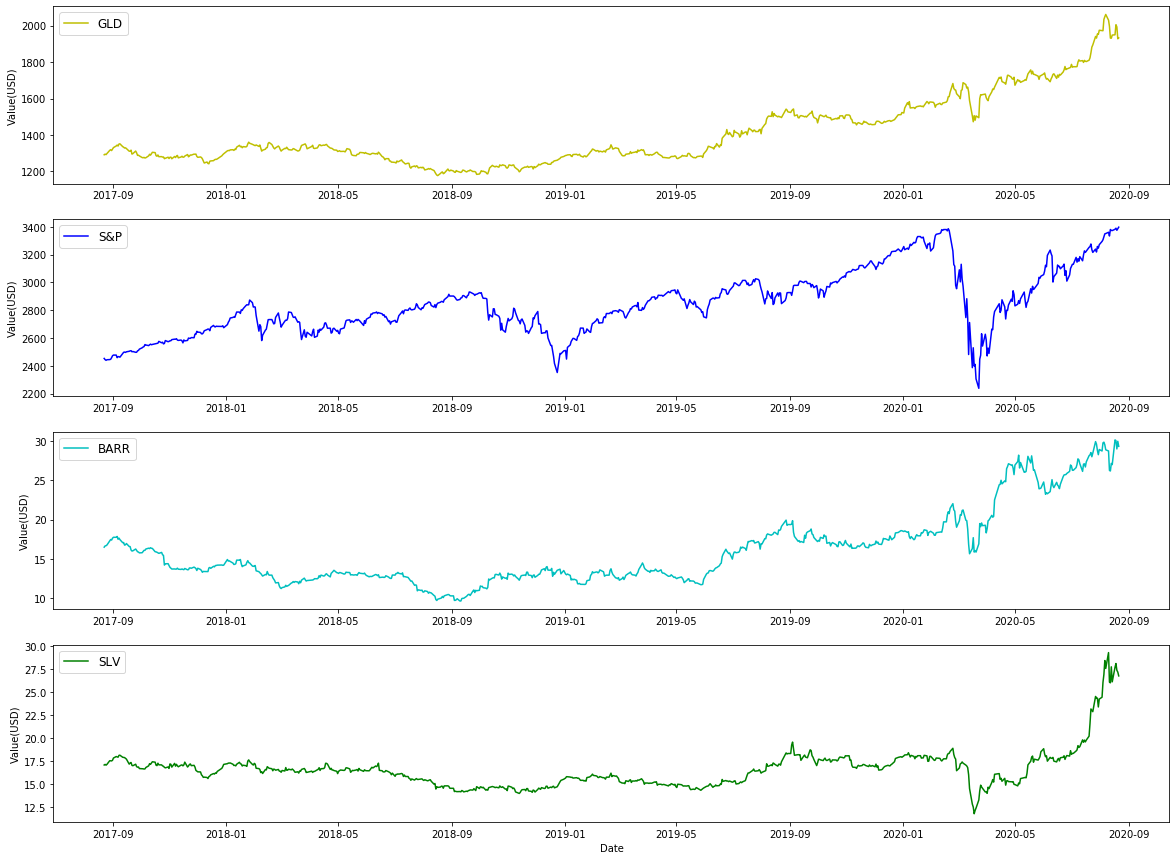

In [14]:
# Take a look at how they compare:
plt.figure(figsize=(20,15))
plt.subplot(411)
plt.plot(maindf['GLD(USD)'], label='GLD', color='y')
plt.legend(loc='best', fontsize='large')
plt.ylabel('Value(USD)')
plt.subplot(412)
plt.plot(maindf['SPX(USD)'], label='S&P', color='b')
plt.legend(loc='best', fontsize='large')
plt.ylabel('Value(USD)')
plt.subplot(413)
plt.plot(maindf['BARR(USD)'], label='BARR', color='c')
plt.legend(loc='best', fontsize='large')
plt.ylabel('Value(USD)')
plt.subplot(414)
plt.plot(maindf['SLV(USD)'], label='SLV', color='g')
plt.legend(loc='best', fontsize='large')
plt.xlabel('Date')
plt.ylabel('Value(USD)')

Well, just from looking at them, it seems like there might be some truth to this. Around the time of the first lockdowns in 2020 we can clearly see that GLD increased as SPX decreased. Along with this, it seems as Barrick Gold Corp (GOLD) and silver also trended with gold. 

Text(0.5, 1.05, 'Correlation of MainDF Features')

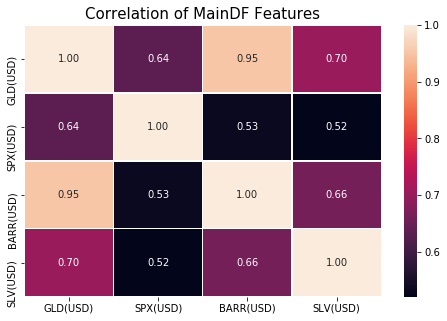

In [15]:
corr = maindf.corr()
plt.figure(figsize = (8,5))
sns.heatmap(corr,
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values,
           annot=True, fmt='.2f', linewidths=.30)
plt.title('Correlation of MainDF Features', y =1.05,  size=15)

That's a lot easier to read and make note of correlations. It looks like the value of gold (GLD) is significantly correlated with the value of the SPX. In addition, silvers correlation to Barrick Gold Corp makes sense as they probably trade in silver as well.

In [16]:
# Correlation Scores:
print(corr['GLD(USD)'].sort_values(ascending =False), '\n')

GLD(USD)     1.000000
BARR(USD)    0.951410
SLV(USD)     0.704224
SPX(USD)     0.636223
Name: GLD(USD), dtype: float64 



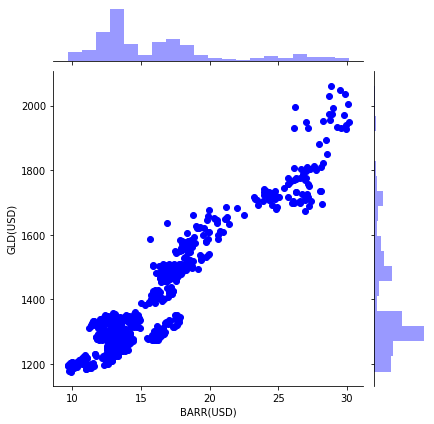

In [17]:
# Using jointplotto visualize relation of GLD with other variables
sns.jointplot(x=maindf['BARR(USD)'], y=maindf['GLD(USD)'], color='blue')

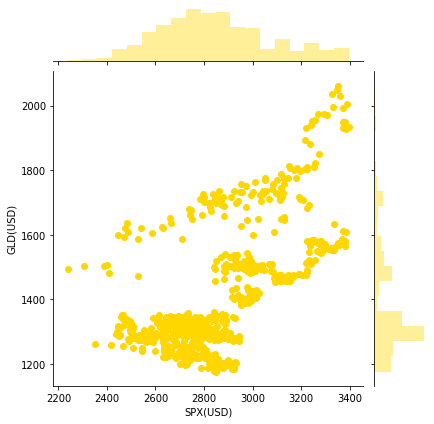

In [18]:
# How about S&P500 and GLD?
sns.jointplot(x= maindf['SPX(USD)'], y=maindf['GLD(USD)'], color='gold')

A quick way to test how two time-series may be  is to check for cointergration. First with an CADF test and then a Johansen Test. [Here is the reference for a pre-written Johansen test.](https://blog.quantinsti.com/johansen-test-cointegration-building-stationary-portfolio/)

The ADF test is in dependent on us making the time series stationary, which we will do by differencing. It is also sensitive to which columns we assign to X and y. The Johansen Cointegration test, however, is not sensitive to which features are assigned to X or Y, and can test for cointegration among 12 time series.

0.5029819219246934


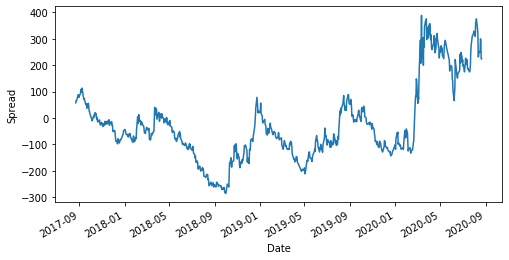

In [19]:
model = sm.OLS(maindf['GLD(USD)'].iloc[:90], maindf['SPX(USD)'].iloc[:90])
model = model.fit() 
print(model.params[0])
#Spread
maindf['spread'] = maindf['GLD(USD)'] - model.params[0] *  maindf['SPX(USD)']
# Plot the spread
maindf['spread'].plot(figsize=(8,4))
plt.ylabel("Spread")
plt.show()

In [20]:
# Compute ADF test statistics
adf = adfuller(maindf.spread, maxlag = 1)
adf[0]

-1.4400066918668435

In [21]:
adf[4]

{'1%': -3.4390179167598367,
 '5%': -2.8653655786032237,
 '10%': -2.5688071343462777}

Conclusion: Since -1.44 > -2.86, the CADF test tells us that there is not a significant cointegration between the GLD and SPX.

Lets see if the Johansen Test supports this.

In [22]:
'''
function result = johansen(x,p,k)
% PURPOSE: perform Johansen cointegration tests
% -------------------------------------------------------
% USAGE: result = johansen(x,p,k)
% where:      x = input matrix of time-series in levels, (nobs x m)
%             p = order of time polynomial in the null-hypothesis
%                 p = -1, no deterministic part
%                 p =  0, for constant term
%                 p =  1, for constant plus time-trend
%                 p >  1, for higher order polynomial
%             k = number of lagged difference terms used when
%                 computing the estimator
% -------------------------------------------------------
% RETURNS: a results structure:
%          result.eig  = eigenvalues  (m x 1)
%          result.evec = eigenvectors (m x m), where first
%                        r columns are normalized coint vectors
%          result.lr1  = likelihood ratio trace statistic for r=0 to m-1
%                        (m x 1) vector
%          result.lr2  = maximum eigenvalue statistic for r=0 to m-1
%                        (m x 1) vector
%          result.cvt  = critical values for trace statistic
%                        (m x 3) vector [90% 95% 99%]
%          result.cvm  = critical values for max eigen value statistic
%                        (m x 3) vector [90% 95% 99%]
%          result.ind  = index of co-integrating variables ordered by
%                        size of the eigenvalues from large to small
% -------------------------------------------------------
% NOTE: c_sja(), c_sjt() provide critical values generated using
%       a method of MacKinnon (1994, 1996).
%       critical values are available for n<=12 and -1 <= p <= 1,
%       zeros are returned for other cases.
% -------------------------------------------------------
% SEE ALSO: prt_coint, a function that prints results
% -------------------------------------------------------
% References: Johansen (1988), 'Statistical Analysis of Co-integration
% vectors', Journal of Economic Dynamics and Control, 12, pp. 231-254.
% MacKinnon, Haug, Michelis (1996) 'Numerical distribution
% functions of likelihood ratio tests for cointegration',
% Queen's University Institute for Economic Research Discussion paper.
% (see also: MacKinnon's JBES 1994 article
% -------------------------------------------------------

% written by:
% James P. LeSage, Dept of Economics
% University of Toledo
% 2801 W. Bancroft St,
% Toledo, OH 43606
% jlesage@spatial-econometrics.com

% ****************************************************************
% NOTE: Adina Enache provided some bug fixes and corrections that
%       she notes below in comments. 4/10/2000
% ****************************************************************
'''

import numpy as np
from numpy import zeros, ones, flipud, log
from numpy.linalg import inv, eig, cholesky as chol
from statsmodels.regression.linear_model import OLS


tdiff = np.diff

class Holder(object):
    pass

def rows(x):
    return x.shape[0]

def trimr(x, front, end):
    if end > 0:
        return x[front:-end]
    else:
        return x[front:]

import statsmodels.tsa.tsatools as tsat
mlag = tsat.lagmat

def mlag_(x, maxlag):
    '''return all lags up to maxlag
    '''
    return x[:-lag]

def lag(x, lag):
    return x[:-lag]

def detrend(y, order):
    if order == -1:
        return y
    return OLS(y, np.vander(np.linspace(-1, 1, len(y)), order + 1)).fit().resid

def resid(y, x):
    r = y - np.dot(x, np.dot(np.linalg.pinv(x), y))
    return r




def coint_johansen(x, p, k, print_on_console=True):

    #    % error checking on inputs
    #    if (nargin ~= 3)
    #     error('Wrong # of inputs to johansen')
    #    end
    nobs, m = x.shape

    # why this?  f is detrend transformed series, p is detrend data
    if (p > -1):
        f = 0
    else:
        f = p

    x = detrend(x, p)
    dx = tdiff(x, 1, axis=0)
    # dx    = trimr(dx,1,0)
    z = mlag(dx, k)  # [k-1:]
#    print z.shape
    z = trimr(z, k, 0)
    z = detrend(z, f)
#    print dx.shape
    dx = trimr(dx, k, 0)

    dx = detrend(dx, f)
    # r0t   = dx - z*(z\dx)
    r0t = resid(dx, z)  # diff on lagged diffs
    # lx = trimr(lag(x,k),k,0)
    lx = lag(x, k)
    lx = trimr(lx, 1, 0)
    dx = detrend(lx, f)
#    print 'rkt', dx.shape, z.shape
    # rkt   = dx - z*(z\dx)
    rkt = resid(dx, z)  # level on lagged diffs
    skk = np.dot(rkt.T, rkt) / rows(rkt)
    sk0 = np.dot(rkt.T, r0t) / rows(rkt)
    s00 = np.dot(r0t.T, r0t) / rows(r0t)
    sig = np.dot(sk0, np.dot(inv(s00), (sk0.T)))
    tmp = inv(skk)
    # du, au = eig(np.dot(tmp, sig))
    au, du = eig(np.dot(tmp, sig))  # au is eval, du is evec
    # orig = np.dot(tmp, sig)

    # % Normalize the eigen vectors such that (du'skk*du) = I
    temp = inv(chol(np.dot(du.T, np.dot(skk, du))))
    dt = np.dot(du, temp)


    # JP: the next part can be done much  easier

    # %      NOTE: At this point, the eigenvectors are aligned by column. To
    # %            physically move the column elements using the MATLAB sort,
    # %            take the transpose to put the eigenvectors across the row

    # dt = transpose(dt)

    # % sort eigenvalues and vectors

    # au, auind = np.sort(diag(au))
    auind = np.argsort(au)
    # a = flipud(au)
    aind = flipud(auind)
    a = au[aind]
    # d = dt[aind,:]
    d = dt[:, aind]

    # %NOTE: The eigenvectors have been sorted by row based on auind and moved to array "d".
    # %      Put the eigenvectors back in column format after the sort by taking the
    # %      transpose of "d". Since the eigenvectors have been physically moved, there is
    # %      no need for aind at all. To preserve existing programming, aind is reset back to
    # %      1, 2, 3, ....

    # d  =  transpose(d)
    # test = np.dot(transpose(d), np.dot(skk, d))

    # %EXPLANATION:  The MATLAB sort function sorts from low to high. The flip realigns
    # %auind to go from the largest to the smallest eigenvalue (now aind). The original procedure
    # %physically moved the rows of dt (to d) based on the alignment in aind and then used
    # %aind as a column index to address the eigenvectors from high to low. This is a double
    # %sort. If you wanted to extract the eigenvector corresponding to the largest eigenvalue by,
    # %using aind as a reference, you would get the correct eigenvector, but with sorted
    # %coefficients and, therefore, any follow-on calculation would seem to be in error.
    # %If alternative programming methods are used to evaluate the eigenvalues, e.g. Frame method
    # %followed by a root extraction on the characteristic equation, then the roots can be
    # %quickly sorted. One by one, the corresponding eigenvectors can be generated. The resultant
    # %array can be operated on using the Cholesky transformation, which enables a unit
    # %diagonalization of skk. But nowhere along the way are the coefficients within the
    # %eigenvector array ever changed. The final value of the "beta" array using either method
    # %should be the same.


    # % Compute the trace and max eigenvalue statistics */
    lr1 = zeros(m)
    lr2 = zeros(m)
    cvm = zeros((m, 3))
    cvt = zeros((m, 3))
    iota = ones(m)
    t, junk = rkt.shape
    for i in range(0, m):
        tmp = trimr(log(iota - a), i , 0)
        lr1[i] = -t * np.sum(tmp, 0)  # columnsum ?
        # tmp = np.log(1-a)
        # lr1[i] = -t * np.sum(tmp[i:])
        lr2[i] = -t * log(1 - a[i])
        cvm[i, :] = c_sja(m - i, p)
        cvt[i, :] = c_sjt(m - i, p)
        aind[i] = i
    # end

    result = Holder()
    # % set up results structure
    # estimation results, residuals
    result.rkt = rkt
    result.r0t = r0t
    result.eig = a
    result.evec = d  # transposed compared to matlab ?
    result.lr1 = lr1
    result.lr2 = lr2
    result.cvt = cvt
    result.cvm = cvm
    result.ind = aind
    result.meth = 'johansen'

    if print_on_console == True:
        print ('--------------------------------------------------')
        print ('--> Trace Statistics')
        print ('variable statistic Crit-90% Crit-95%  Crit-99%')
        for i in range(len(result.lr1)):
            print ('r =', i, '\t', round(result.lr1[i], 4), result.cvt[i, 0], result.cvt[i, 1], result.cvt[i, 2])
        print ('--------------------------------------------------')
        print ('--> Eigen Statistics')
        print ('variable statistic Crit-90% Crit-95%  Crit-99%')
        for i in range(len(result.lr2)):
            print ('r =', i, '\t', round(result.lr2[i], 4), result.cvm[i, 0], result.cvm[i, 1], result.cvm[i, 2])
        print ('--------------------------------------------------')
        print ('eigenvectors:\n', result.evec)
        print ('--------------------------------------------------')
        print ('eigenvalues:\n', result.eig)
        print ('--------------------------------------------------')


    return result

def c_sjt(n, p):

# PURPOSE: find critical values for Johansen trace statistic
# ------------------------------------------------------------
# USAGE:  jc = c_sjt(n,p)
# where:    n = dimension of the VAR system
#               NOTE: routine doesn't work for n > 12
#           p = order of time polynomial in the null-hypothesis
#                 p = -1, no deterministic part
#                 p =  0, for constant term
#                 p =  1, for constant plus time-trend
#                 p >  1  returns no critical values
# ------------------------------------------------------------
# RETURNS: a (3x1) vector of percentiles for the trace
#          statistic for [90# 95# 99#]
# ------------------------------------------------------------
# NOTES: for n > 12, the function returns a (3x1) vector of zeros.
#        The values returned by the function were generated using
#        a method described in MacKinnon (1996), using his FORTRAN
#        program johdist.f
# ------------------------------------------------------------
# SEE ALSO: johansen()
# ------------------------------------------------------------
# # References: MacKinnon, Haug, Michelis (1996) 'Numerical distribution
# functions of likelihood ratio tests for cointegration',
# Queen's University Institute for Economic Research Discussion paper.
# -------------------------------------------------------

# written by:
# James P. LeSage, Dept of Economics
# University of Toledo
# 2801 W. Bancroft St,
# Toledo, OH 43606
# jlesage@spatial-econometrics.com
#
# Ported to Python by Javier Garcia
# javier.macro.trader@gmail.com

# these are the values from Johansen's 1995 book
# for comparison to the MacKinnon values
# jcp0 = [ 2.98   4.14   7.02
#        10.35  12.21  16.16
#        21.58  24.08  29.19
#        36.58  39.71  46.00
#        55.54  59.24  66.71
#        78.30  86.36  91.12
#       104.93 109.93 119.58
#       135.16 140.74 151.70
#       169.30 175.47 187.82
#       207.21 214.07 226.95
#       248.77 256.23 270.47
#       293.83 301.95 318.14];




    jcp0 = ((2.9762, 4.1296, 6.9406),
            (10.4741, 12.3212, 16.3640),
            (21.7781, 24.2761, 29.5147),
            (37.0339, 40.1749, 46.5716),
            (56.2839, 60.0627, 67.6367),
            (79.5329, 83.9383, 92.7136),
            (106.7351, 111.7797, 121.7375),
            (137.9954, 143.6691, 154.7977),
            (173.2292, 179.5199, 191.8122),
            (212.4721, 219.4051, 232.8291),
            (255.6732, 263.2603, 277.9962),
            (302.9054, 311.1288, 326.9716))


    jcp1 = ((2.7055, 3.8415, 6.6349),
            (13.4294, 15.4943, 19.9349),
            (27.0669, 29.7961, 35.4628),
            (44.4929, 47.8545, 54.6815),
            (65.8202, 69.8189, 77.8202),
            (91.1090, 95.7542, 104.9637),
            (120.3673, 125.6185, 135.9825),
            (153.6341, 159.5290, 171.0905),
            (190.8714, 197.3772, 210.0366),
            (232.1030, 239.2468, 253.2526),
            (277.3740, 285.1402, 300.2821),
            (326.5354, 334.9795, 351.2150))

    jcp2 = ((2.7055, 3.8415, 6.6349),
            (16.1619, 18.3985, 23.1485),
            (32.0645, 35.0116, 41.0815),
            (51.6492, 55.2459, 62.5202),
            (75.1027, 79.3422, 87.7748),
            (102.4674, 107.3429, 116.9829),
            (133.7852, 139.2780, 150.0778),
            (169.0618, 175.1584, 187.1891),
            (208.3582, 215.1268, 228.2226),
            (251.6293, 259.0267, 273.3838),
            (298.8836, 306.8988, 322.4264),
            (350.1125, 358.7190, 375.3203))



    if (p > 1) or (p < -1):
        jc = (0, 0, 0)
    elif (n > 12) or (n < 1):
        jc = (0, 0, 0)
    elif p == -1:
        jc = jcp0[n - 1]
    elif p == 0:
        jc = jcp1[n - 1]
    elif p == 1:
        jc = jcp2[n - 1]



    return jc

def c_sja(n, p):

# PURPOSE: find critical values for Johansen maximum eigenvalue statistic
# ------------------------------------------------------------
# USAGE:  jc = c_sja(n,p)
# where:    n = dimension of the VAR system
#           p = order of time polynomial in the null-hypothesis
#                 p = -1, no deterministic part
#                 p =  0, for constant term
#                 p =  1, for constant plus time-trend
#                 p >  1  returns no critical values
# ------------------------------------------------------------
# RETURNS: a (3x1) vector of percentiles for the maximum eigenvalue
#          statistic for: [90# 95# 99#]
# ------------------------------------------------------------
# NOTES: for n > 12, the function returns a (3x1) vector of zeros.
#        The values returned by the function were generated using
#        a method described in MacKinnon (1996), using his FORTRAN
#        program johdist.f
# ------------------------------------------------------------
# SEE ALSO: johansen()
# ------------------------------------------------------------
# References: MacKinnon, Haug, Michelis (1996) 'Numerical distribution
# functions of likelihood ratio tests for cointegration',
# Queen's University Institute for Economic Research Discussion paper.
# -------------------------------------------------------

# written by:
# James P. LeSage, Dept of Economics
# University of Toledo
# 2801 W. Bancroft St,
# Toledo, OH 43606
# jlesage@spatial-econometrics.com
# Ported to Python by Javier Garcia
# javier.macro.trader@gmail.com


    jcp0 = ((2.9762, 4.1296, 6.9406),
            (9.4748, 11.2246, 15.0923),
            (15.7175, 17.7961, 22.2519),
            (21.8370, 24.1592, 29.0609),
            (27.9160, 30.4428, 35.7359),
            (33.9271, 36.6301, 42.2333),
            (39.9085, 42.7679, 48.6606),
            (45.8930, 48.8795, 55.0335),
            (51.8528, 54.9629, 61.3449),
            (57.7954, 61.0404, 67.6415),
            (63.7248, 67.0756, 73.8856),
            (69.6513, 73.0946, 80.0937))

    jcp1 = ((2.7055, 3.8415, 6.6349),
            (12.2971, 14.2639, 18.5200),
            (18.8928, 21.1314, 25.8650),
            (25.1236, 27.5858, 32.7172),
            (31.2379, 33.8777, 39.3693),
            (37.2786, 40.0763, 45.8662),
            (43.2947, 46.2299, 52.3069),
            (49.2855, 52.3622, 58.6634),
            (55.2412, 58.4332, 64.9960),
            (61.2041, 64.5040, 71.2525),
            (67.1307, 70.5392, 77.4877),
            (73.0563, 76.5734, 83.7105))

    jcp2 = ((2.7055, 3.8415, 6.6349),
            (15.0006, 17.1481, 21.7465),
            (21.8731, 24.2522, 29.2631),
            (28.2398, 30.8151, 36.1930),
            (34.4202, 37.1646, 42.8612),
            (40.5244, 43.4183, 49.4095),
            (46.5583, 49.5875, 55.8171),
            (52.5858, 55.7302, 62.1741),
            (58.5316, 61.8051, 68.5030),
            (64.5292, 67.9040, 74.7434),
            (70.4630, 73.9355, 81.0678),
            (76.4081, 79.9878, 87.2395))


    if (p > 1) or (p < -1):
        jc = (0, 0, 0)
    elif (n > 12) or (n < 1):
        jc = (0, 0, 0)
    elif p == -1:
        jc = jcp0[n - 1]
    elif p == 0:
        jc = jcp1[n - 1]
    elif p == 1:
        jc = jcp2[n - 1]


    return jc


In [23]:
SPX = maindf['SPX(USD)']
GLD = maindf['GLD(USD)']
BARR= maindf['BARR(USD)']
SLV = maindf['SLV(USD)']

df= pd.DataFrame({'x':GLD, 'y':SPX})
print(coint_johansen(df,0,1))

--------------------------------------------------
--> Trace Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 8.381 13.4294 15.4943 19.9349
r = 1 	 0.7666 2.7055 3.8415 6.6349
--------------------------------------------------
--> Eigen Statistics
variable statistic Crit-90% Crit-95%  Crit-99%
r = 0 	 7.6144 12.2971 14.2639 18.52
r = 1 	 0.7666 2.7055 3.8415 6.6349
--------------------------------------------------
eigenvectors:
 [[ 0.00551903 -0.00431493]
 [-0.00560927 -0.00126722]]
--------------------------------------------------
eigenvalues:
 [0.01000827 0.00101216]
--------------------------------------------------


Well, they certainly don't have a Johansen cointegration score of anything signifcant. However, we could try one more method: [Granger Causality.](https://towardsdatascience.com/granger-causality-and-vector-auto-regressive-model-for-time-series-forecasting-3226a64889a6) Granger Causality test, in short, simply test time series to see if they are useful in forecasting other time series. However, using them for anything outside of economics, as warned by Clive Granger himself, is "ridiculous."

In [24]:
# We have 759 rows, so 20% would be a test size of ~152
n_obs=152
X_train, X_test = maindf[0:-n_obs], maindf[-n_obs:]
print(X_train.shape, X_test.shape)

(607, 5) (152, 5)


In [25]:
X_train_transformed = X_train.diff().dropna()
X_train_transformed.head()

,GLD(USD),SPX(USD),BARR(USD),SLV(USD),spread
Date,,,,,
2017-08-23,3.7,-8.47,0.1567,0.066,7.960257
2017-08-24,-2.7,-5.07,0.0293,-0.080,-0.149882
2017-08-25,5.9,4.08,0.0882,0.086,3.847834
2017-08-28,17.4,1.19,0.5189,0.397,16.801452
2017-08-29,3.6,2.06,0.1762,-0.013,2.563857


In [26]:
X_train_transformed.describe()

,GLD(USD),SPX(USD),BARR(USD),SLV(USD),spread
count,606.000000,606.000000,606.000000,606.000000,606.000000
mean,0.430528,1.380825,0.002298,0.001531,-0.264002
std,9.187826,23.856209,0.270413,0.193687,14.656545
min,-37.650000,-113.190000,-1.470000,-0.782000,-59.425700
25%,-4.700000,-7.532500,-0.138150,-0.090000,-8.553185
50%,0.450000,2.180000,0.000000,0.000000,-1.135763
75%,5.550000,13.822500,0.137825,0.110000,6.726457
max,39.250000,137.730000,1.069600,0.926400,65.315352


In [27]:
# let's see if the ADF says it's stationary now.
def augmented_dickey_fuller_statistics(time_series):
    result = adfuller(time_series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
print('Augmented Dickey-Fuller Test: Gold Price Time Series')
augmented_dickey_fuller_statistics(X_train_transformed['GLD(USD)'])
print('Augmented Dickey-Fuller Test: SPX Price Time Series')
augmented_dickey_fuller_statistics(X_train_transformed['SPX(USD)'])


Augmented Dickey-Fuller Test: Gold Price Time Series
ADF Statistic: -4.774041
p-value: 0.000061
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
Augmented Dickey-Fuller Test: SPX Price Time Series
ADF Statistic: -12.695757
p-value: 0.000000
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


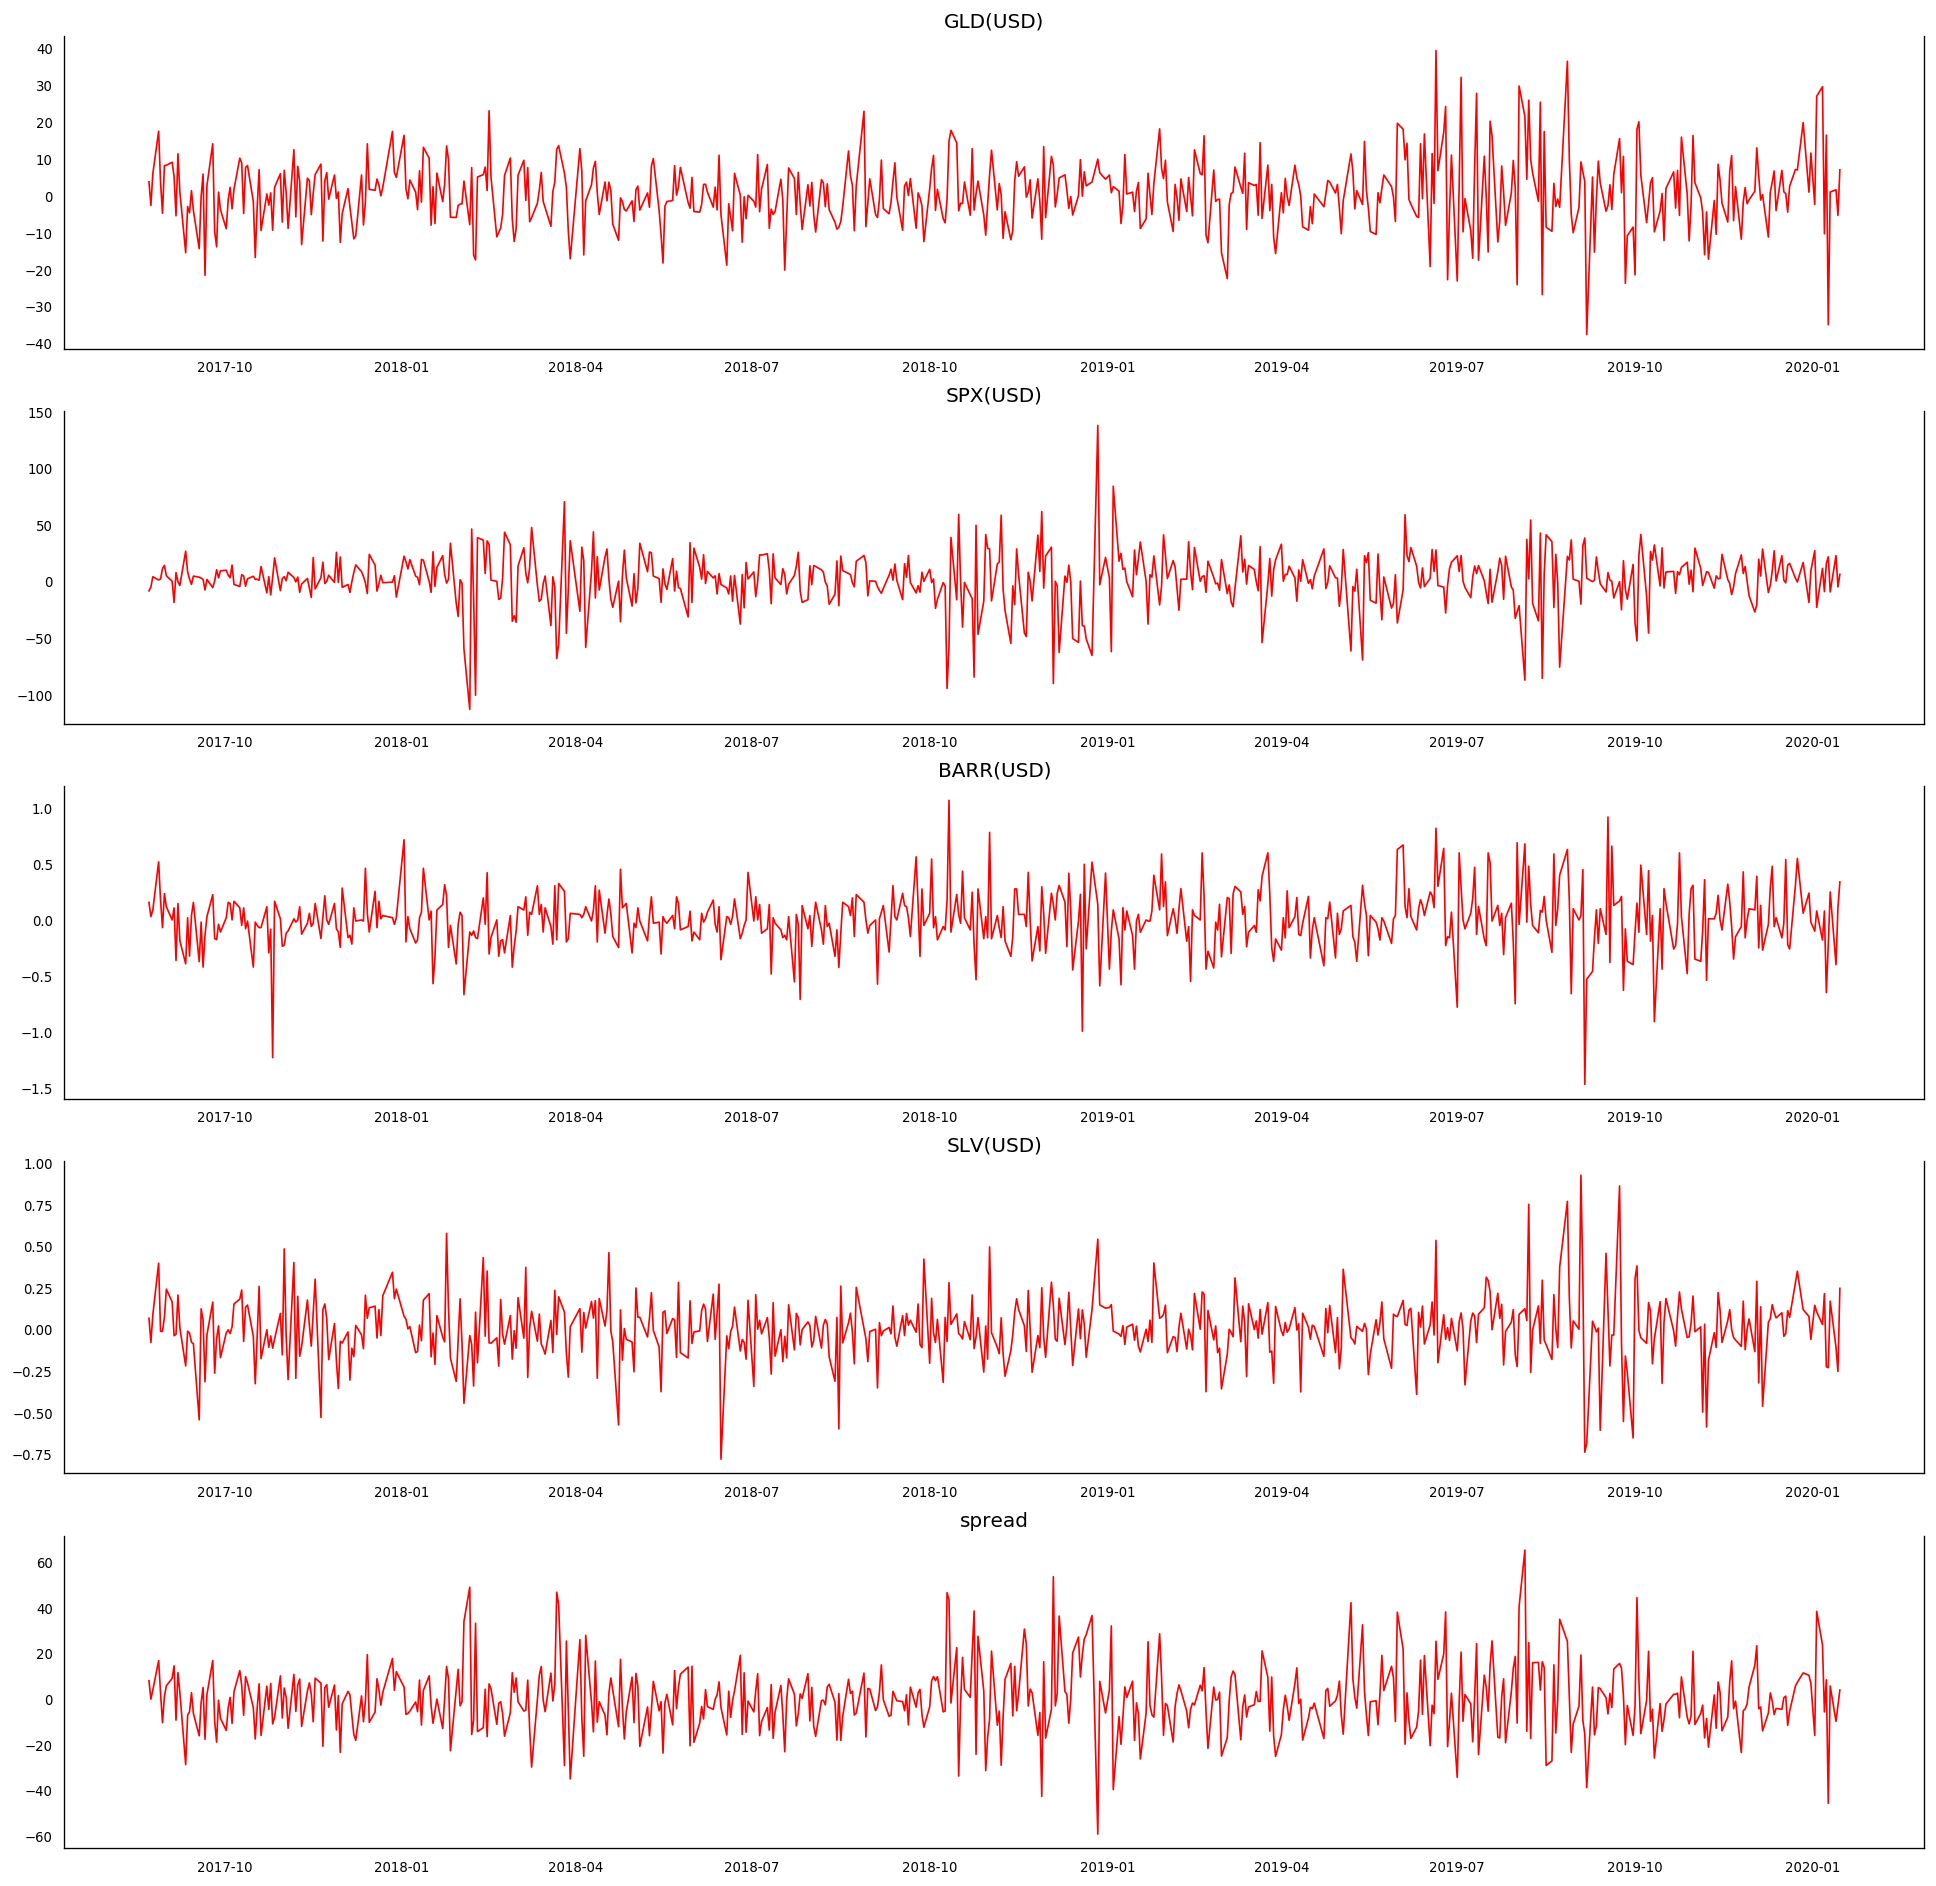

In [28]:
# lets look at each of them displayed out to see that they are stationary
fig, axes = plt.subplots(nrows=5, ncols=1, dpi=120, figsize=(20,20))
for i, ax in enumerate(axes.flatten()):
    d = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(d, color='red', linewidth=1)
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=8)
plt.show();

In [29]:
# now that they are stationary we can test for Granger Causality!

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12

test = 'ssr-chi2test'

def grangers_causality_matrix(data, variables, test = 'ssr_chi2test', verbose=False):

    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)

    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(data[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')

            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value

    dataset.columns = [var + '_x' for var in variables]

    dataset.index = [var + '_y' for var in variables]

    return dataset

grangers_causality_matrix(X_train_transformed, variables = X_train_transformed.columns)  

,GLD(USD)_x,SPX(USD)_x,BARR(USD)_x,SLV(USD)_x,spread_x
GLD(USD)_y,1.0000,0.0388,0.0000,0.0000,0.0388
SPX(USD)_y,0.0642,1.0000,0.0077,0.0043,0.0642
BARR(USD)_y,0.1356,0.0127,1.0000,0.0024,0.0949
SLV(USD)_y,0.5869,0.1145,0.0085,1.0000,0.1674
spread_y,0.0753,0.0753,0.0000,0.0000,1.0000


To understand what we have here:

Row 1, column 2 refers to the p-value of the Granger's Causality test for SPX(USD)_x causing GLD(USD)_y. What we see is a p-value of 0.0388. That is a significant p-value, as it is under the level of significance (0.05)! So, according to the Granger Causality, we could reject the null hypothesis and say with 95% confidence that SPX causes GLD.

All right, so, what now? Well, the CADF and Johansen test both told us that there was no significance. However, Granger Causality did make a case for significance. perhaps the best way to conclude this is to conduct the ARIMAX test.  

Credit for the cross-validation model below: [Maytsup Github](https://github.com/maytusp/stock)

## Part 3: Pre-processing and Training

In [30]:
# We will need to calculate the Root of the Mean Squarred Error in order to determine the best set of parameters. 
# Function for calculating the RMSE:

def RMSEfromResid(X):
    summ = 0
    for i in X:
        summ+=i**2
    return((summ/len(X))**0.5)

### The issue:
Below is the cross validation method I am using to find the ideal parameters for testing. However, after running said cross validation, I cannot get the test to work and I repeatedly get: 
"LinAlgError: SVD did not converge"
Unfortunately, this seems to be due to a recent update from statsmodels. I will return periodically to see test out solutions. However, since the model is not overly complex and we are not tracking several time series, we shouldn't have to use any p,d,q values beyond 2 or 3.

In [31]:
# Train-Test-Split:
maindf['diffGLD'] = maindf['GLD(USD)'].diff()
maindf['diffSPX'] = maindf['SPX(USD)'].diff()
date = maindf.index
maindf['SPX_lag']=maindf['diffSPX'].shift()
maindf.dropna(inplace=True)
GLD_end = maindf['GLD(USD)']
SPX_ex = maindf['SPX_lag']
m = len(GLD_end)
size = int(len(GLD_end)*0.8)
train, test = GLD_end[0:size], GLD_end[size:m]
ex_train, ex_test = SPX_ex[0:size], SPX_ex[size:m]
date_test = date[size:]

def evaluate_arimax_model(y, X, model_order):
    model_arimax = ARIMA(endog = y, exog=X, order=model_order).fit()
    AIC = model_arimax.aic
    BIC = model_arimax.bic
    LLF = model_arimax.llf
    RMSE = RMSEfromResid(model_arimax.resid)
    return([AIC, BIC, LLF, RMSE])

warnings.filterwarnings("ignore")
p_values = [0,1,2,3]
d_values = [1]
q_values = [0,1,2]
data = list()
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            try:
                [AIC, BIC, LLF, RMSE] = evaluate_arimax_model(train, ex_train, order)
                data.append([order,AIC, BIC, LLF, RMSE])
            except:
                continue

ARIMAX_Models = pd.DataFrame(data,columns=['ARIMAX', 'AIC', 'BIC', 'Maximum Log-Likelihood', 'RMSE'],dtype=float)

evaluate_arimax_model(train, ex_train, order)
ARIMAX_Models.sort_values(by=['RMSE'])

,ARIMAX,AIC,BIC,Maximum Log-Likelihood,RMSE
11,"(3, 1, 2)",4396.570311,4431.798905,-2190.285156,9.091726
10,"(3, 1, 1)",4394.578178,4425.403198,-2190.289089,9.091785
8,"(2, 1, 2)",4395.040913,4425.865933,-2190.520457,9.095262
7,"(2, 1, 1)",4393.131283,4419.552728,-2190.565641,9.095948
5,"(1, 1, 2)",4393.183557,4419.605002,-2190.591778,9.096337
9,"(3, 1, 0)",4398.151767,4424.573212,-2193.075884,9.133846
2,"(0, 1, 2)",4398.040853,4420.058724,-2194.020426,9.148135
6,"(2, 1, 0)",4398.594011,4420.611882,-2194.297005,9.152304
1,"(0, 1, 1)",4397.553620,4415.167917,-2194.776810,9.159555
3,"(1, 1, 0)",4397.583320,4415.197617,-2194.791660,9.159780


In [32]:
# For predicting from grid search cv
from sktime.performance_metrics.forecasting import smape_loss
history = [x for x in train]
his_u = ex_train
predictions = list()
data=list()
test_index = list()
for t in range(len(ex_test)):
    model_arimax = ARIMA(endog = history,exog=his_u, order=(2, 1, 1)).fit(disp=0)
    output = model_arimax.forecast(steps=1, exog=ex_test.iloc[[t]])
    yhat = output[0]
    predictions.append(yhat)
    history.append(test[t])
    test_index.append(t)
    his_u = ex_train.append(ex_test.iloc[test_index])
    data.append([date_test[t], test[t], yhat])


RMSE = (mean_squared_error(test, predictions))**0.5
arima_results = pd.DataFrame(data,columns=['Period','Actual Price', 'Predicted Price'],dtype=float)
print('Test RMSE: %.3f' % RMSE)

Test RMSE: 22.947


Sweet, so we have an RMSE that, in comparison to our the magnitude of our data, is quite low. However, can we simplify this information into a form for presenting to stakeholders that is clearer and easier to understand? Yes! We can use Mean Absolute Percentage Error, or MAPE for short! More about the pros and cons of MAPE can be found [here](https://towardsdatascience.com/choosing-the-correct-error-metric-mape-vs-smape-5328dec53fac). Bottom line is that the lower the percentage, the better our forecast model is at predicting the actual test results.

In [33]:
# Let's visualize the accuracy of the predictions to the test data with MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

print('The Mean Absolute Percentage Error is: %.3f' % mape(np.array(test), predictions),'%.')

The Mean Absolute Percentage Error is: 8.369 %.


## Part 4: Modeling

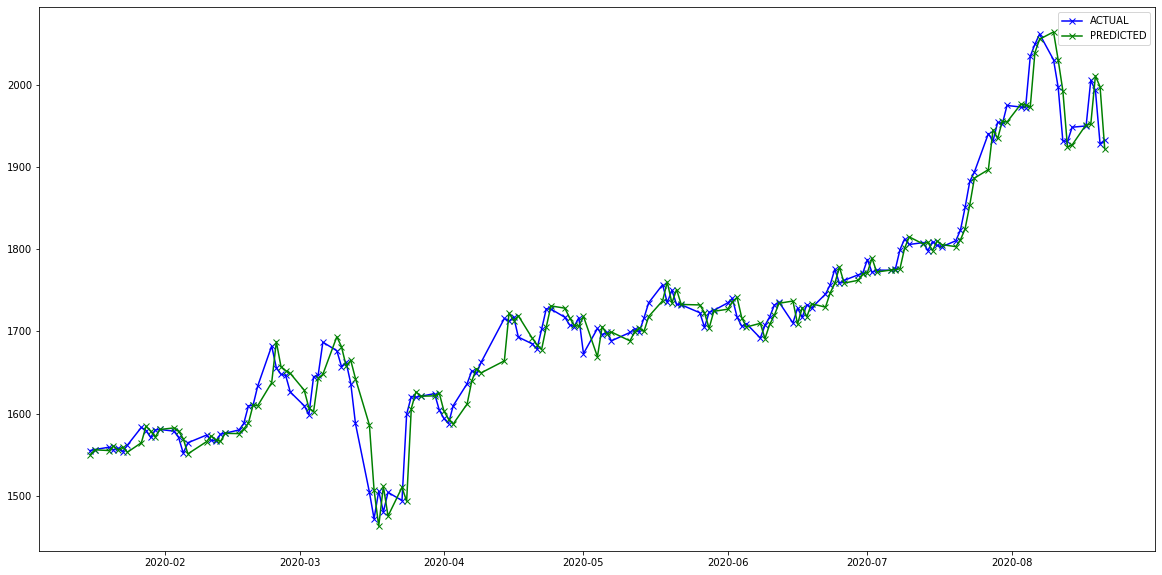

In [34]:
# plot our calculations above to compare prediction to actual trend
plt.rcParams['figure.figsize'] = (20,10)
plt.plot(date_test[2:], test, color='Blue', label='ACTUAL', marker='x')
plt.plot(date_test[2:], predictions, color='green', label='PREDICTED', marker='x')
plt.legend(loc='upper right')
plt.show()
arimax_pred = predictions
arimax_RMSE = RMSE